In [1]:
import glob
import os.path as osp
import pickle
import random
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

import datasets.dataset as dataset
from datasets.load_adni import load_adni2
import models.models as models
from utils.data_class import BrainDataset
import torchio as tio
from tqdm import tqdm
#from models.models import Vgg16, FujiNet1

/home/ryo32/medical-onbording/.venv/lib/python3.12/site-packages/SimpleITK/extra.py:466: SyntaxWarning: invalid escape sequence '\s'
  """Blurs an image by separable convolution with discrete
/home/ryo32/medical-onbording/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataloader作成時にラベル情報を数値に変換するために使用するdict型変数
CLASS_MAP = {
    "CN": 0,
    "AD": 1,
}
# 再現性を保つために設定しておく値
SEED_VALUE = 0

In [3]:
# seed値を設定（random, Numpy, PyTorch）
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = (
        False  # この行をFalseにすると再現性はとれるが、速度が落ちる
    )
    torch.backends.cudnn.deterministic = True
    return

fix_seed(0)

In [4]:
# 脳MRIの画像を読み込み（今回は"CN", "AD"のみ）
dataset = load_adni2(classes=["CN", "AD"],size="half", unique=True, mni=False, strength=["3.0"])

# datasetの枚数を表示
len(dataset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 571/571 [00:41<00:00, 13.89it/s]


571

In [5]:
# datasetの1枚の情報を見てみる
dataset[0]

{'pid': '098_S_4003',
 'sex': 'F',
 'age': '72.4137',
 'weight': '56.7',
 'day': '2011-03-22',
 'uid': '225425',
 'preprocessing': 'MT1; GradWarp; N3m',
 'slice_thickness': '1.2',
 'plane': 'SAGITTAL',
 'x': '1.0156',
 'y': '1.0156',
 'manufacturer': 'GE MEDICAL SYSTEMS',
 'model': 'DISCOVERY MR750',
 'strength': '3.0',
 'class': 'CN',
 'mmse': '30.0',
 'moca': '24.0',
 'class_base': 'CN',
 'mmse_base': '30.0',
 'moca_base': '24.0',
 'path_full': '/data2/radiology_datas/clean3/ADNI2/full/rigid/225425.nii',
 'path_half': '/data2/radiology_datas/clean3/ADNI2/half/rigid/225425.nii',
 'path_full_mni': '/data2/radiology_datas/clean3/ADNI2/full/trsaa/225425.nii',
 'path_half_mni': '/data2/radiology_datas/clean3/ADNI2/half/trsaa/225425.nii',
 'voxel': memmap([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ...

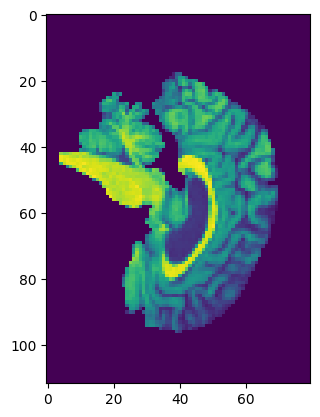

In [6]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][40,:,:])

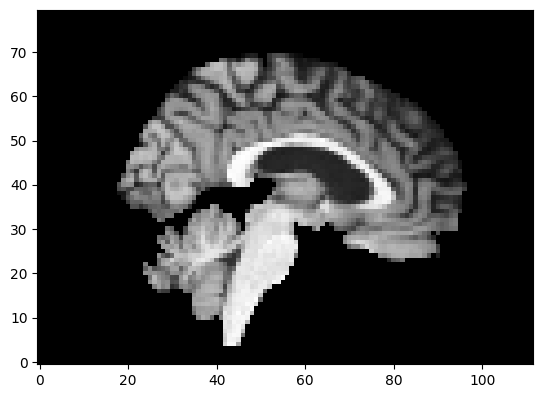

In [7]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][40,:,:].T, origin="lower", cmap="gray")

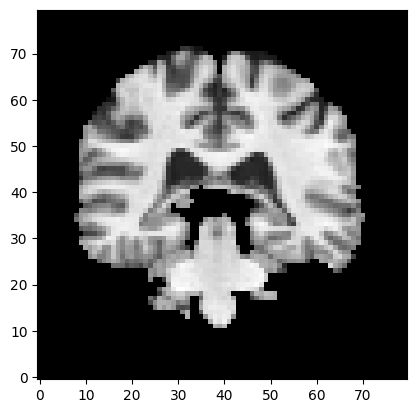

In [8]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][:,48,:].T, origin="lower", cmap="gray")

In [9]:
# datasetの」中から使用する情報をそれぞれ取ってくる
pids = []
voxels = np.zeros((len(dataset), 80, 112, 80))
labels = np.zeros(len(dataset))
for i in tqdm(range(len(dataset))):
    pids.append(dataset[i]["pid"])
    voxels[i] = dataset[i]["voxel"]
    # voxels[i] = normalize(voxels[i], np.min(voxels[i]), np.max(voxels[i]))
    labels[i] = CLASS_MAP[dataset[i]["class"]]
pids = np.array(pids)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 571/571 [00:02<00:00, 257.46it/s]


In [11]:
# trainとtest用の画像を、同じ患者が分かれて入らないように分ける。

from sklearn.model_selection import StratifiedGroupKFold, train_test_split

# train_datadict, val_datadict = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

pids = []
for i in range(len(dataset)):
    pids.append(dataset[i]["pid"])
gss = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE)
train_idx, val_idx = list(gss.split(voxels,labels, groups=pids))[0]
train_voxels = voxels[train_idx]
val_voxels = voxels[val_idx]
train_labels = labels[train_idx]
val_labels = labels[val_idx]

len(train_voxels)

456

In [12]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [13]:
# train/val dataset を作成
train_set = BrainDataset(train_voxels, train_labels)
val_set = BrainDataset(val_voxels, val_labels)

print("size of the training dataset = ", len(train_set))
print("size of the validation dataset = ", len(val_set))
print("training image shape = {}, training label = {}".format(train_set(0)[0].shape, train_set(0)[1]))
print("test image shape = {}, test label = {}".format(val_set(0)[0].shape, val_set(0)[1]))

size of the training dataset =  456
size of the validation dataset =  115
training image shape = (1, 80, 112, 80), training label = 0.0
test image shape = (1, 80, 112, 80), test label = 0.0


In [15]:
# Function line up input images and output images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


def show_image(image):    
    %matplotlib inline

    fig = plt.figure(figsize=(18,5),dpi=600)
    X, Y = 1, 6
    
    for i in range(6):
        imgplot = i + 1
        ax1 = fig.add_subplot(X, Y, imgplot)
        print(f"type={image.dtype}")
        img = np.flip(image.reshape(80, 112, 80).transpose(1,2,0)[50+i],0)
        plt.axis("off")
        plt.imshow(img,cmap="gray")
        plt.tick_params(labelsize=8)
        
    plt.show()

type=float32
type=float32
type=float32
type=float32
type=float32
type=float32


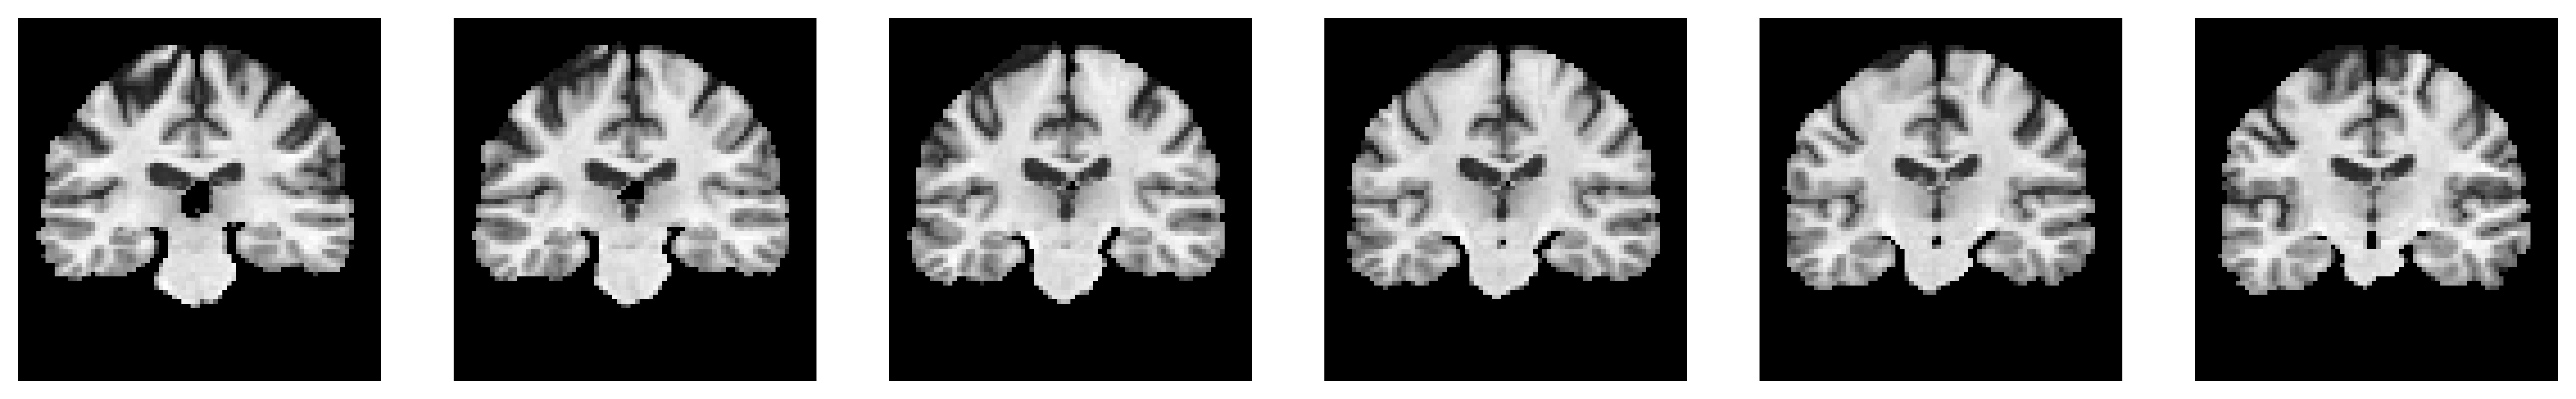

In [16]:
idx = 20
image, label = train_set(idx)

show_image(image)

mean= 0.13431239
max=1.0 min=0.0
0.0


/tmp/ipykernel_16679/589869620.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


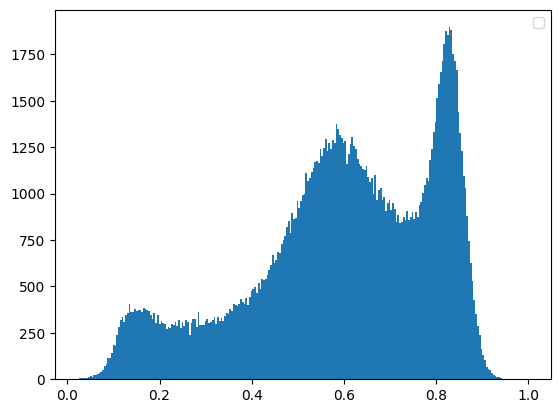

In [17]:
# 画像１枚あたりの輝度値ヒストグラム
print("mean=", image.mean())
print(f"max={image.max()} min={image.min()}")
print(label)
#imge = np.clip(image, 0, None)
show_img = image.reshape(80*112*80)
plt.hist(show_img[show_img > 0.01], bins=255)
#plt.title("Accuracy")
#plt.xlabel("Epoch")
#plt.ylabel("Accuracy")
plt.legend()

571


(array([1.02000e+02, 2.71000e+02, 5.02000e+02, 8.44000e+02, 1.39800e+03,
        2.05400e+03, 2.87700e+03, 3.66600e+03, 4.71100e+03, 6.06900e+03,
        7.46600e+03, 9.24900e+03, 1.14480e+04, 1.41570e+04, 1.69070e+04,
        2.01130e+04, 2.43240e+04, 2.88540e+04, 3.41290e+04, 4.04420e+04,
        4.70330e+04, 5.42280e+04, 6.24160e+04, 7.05740e+04, 7.93940e+04,
        8.94480e+04, 9.89030e+04, 1.08930e+05, 1.19000e+05, 1.29422e+05,
        1.39804e+05, 1.51134e+05, 1.61218e+05, 1.71952e+05, 1.83945e+05,
        1.94296e+05, 2.06093e+05, 2.14392e+05, 2.22193e+05, 2.29637e+05,
        2.35215e+05, 2.38163e+05, 2.39691e+05, 2.39949e+05, 2.38516e+05,
        2.36014e+05, 2.32964e+05, 2.30292e+05, 2.25899e+05, 2.23759e+05,
        2.19174e+05, 2.16044e+05, 2.12820e+05, 2.10655e+05, 2.06574e+05,
        2.04247e+05, 2.00943e+05, 1.98417e+05, 1.95716e+05, 1.92573e+05,
        1.91269e+05, 1.90242e+05, 1.87203e+05, 1.87179e+05, 1.85957e+05,
        1.85255e+05, 1.85051e+05, 1.84688e+05, 1.84

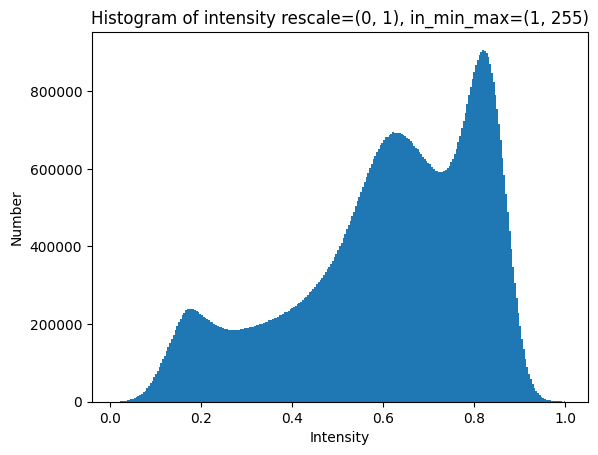

In [18]:
image_list = []
max = 0.01
for image, label in train_set:
    if max < image.max():
        max = image.max()
    image_reshape = image.reshape(80*112*80)
    image_list.append(image_reshape)

for image, label in val_set:
    if max < image.max():
        max = image.max()
    image_reshape = image.reshape(80*112*80)
    image_list.append(image_reshape)
print(len(image_list))

imagelist = np.concatenate(image_list)
plt.title("Histogram of intensity rescale=(0, 1), in_min_max=(1, 255)")
plt.xlabel("Intensity")
plt.ylabel("Number")
plt.hist(imagelist[imagelist > 0.01], bins=255)

In [19]:
print(max)

1.0


In [20]:
train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=16, shuffle=False)

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 3D Conv 例: (1->3->32->64) 3回
        self.conv1 = nn.Conv3d(1, 3, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm3d(3)
        self.conv2 = nn.Conv3d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm3d(64)

        self.pool = nn.AvgPool3d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        
        # ★ここを修正: in_features=89600 に変更
        self.fc1 = nn.Linear(89600, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 2)  # 2クラス (AD/CN)

    def forward_features(self, x):
        """
        畳み込み〜プーリング〜Flatten〜FC1(途中) までを行い、中間特徴を返す
        """
        # conv1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        # conv2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # conv3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flatten
        x = torch.flatten(x, start_dim=1)

        # FC1 -> BN -> Dropout -> ReLU
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.dropout(x)
        x = F.relu(x)

        return x

    def forward(self, x):
        """
        全体のforward: 畳み込み〜FC1特徴 から FC2 で最終出力
        """
        feats = self.forward_features(x)  # ここまでで (B, 512)
        out = self.fc2(feats)             # (B, 2) 2クラス分類
        return out



In [56]:
net = CNN()
print(net)

CNN(
  (conv1): Conv3d(1, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=89600, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [57]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(params=net.parameters(), lr=0.0005, momentum=0.9)
optimizer = optim.Adam(params=net.parameters(), lr=0.001)

In [58]:
def train_model(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):

    #nvidia-smiで確認してからcudaの番号を決める
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    print("Use divice = ", device)
    
    log_path = "./log/" + "output" + "_cnn/"

    for epoch in range(num_epochs):
        # train
        net.train()
        loss_avg = 0.0
        acc_avg = 0.0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            acc_avg += torch.mean((preds == labels).float()).item() / len(train_dataloader)
            loss_avg += loss.item() / len(train_dataloader)
        train_losses.append(loss_avg)
        train_accs.append(acc_avg)

        # evaluate
        loss_avg = 0.0 
        acc_avg = 0.0
        net.eval()
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            with torch.no_grad():
                outputs = net(inputs)
                loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            acc_avg += torch.mean((preds == labels).float()).item() / len(val_dataloader)
            loss_avg += loss.item() / len(val_dataloader)

        test_losses.append(loss_avg)
        test_accs.append(acc_avg)
        print(f"EPOCH {epoch+1}  || train loss : {train_losses[epoch]:.4f}, test loss : {test_losses[epoch]:.4f} || train acc : {train_accs[epoch]:.4f} test acc : {test_accs[epoch]:.4f}")

    torch.save(net.state_dict(), log_path + "cnn_weight_1.pth")

In [59]:
num_epochs = 100

train_losses = []
test_losses = []
train_accs = []
test_accs = []

train_model(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

Use divice =  cuda:0
EPOCH 1  || train loss : 0.6980, test loss : 1.3587 || train acc : 0.6616 test acc : 0.3776
EPOCH 2  || train loss : 0.5065, test loss : 3.7781 || train acc : 0.7371 test acc : 0.3464
EPOCH 3  || train loss : 0.4467, test loss : 1.2769 || train acc : 0.7780 test acc : 0.6693
EPOCH 4  || train loss : 0.3768, test loss : 3.1349 || train acc : 0.8319 test acc : 0.3464
EPOCH 5  || train loss : 0.3074, test loss : 5.1321 || train acc : 0.8685 test acc : 0.3464
EPOCH 6  || train loss : 0.2837, test loss : 2.1474 || train acc : 0.8836 test acc : 0.6536
EPOCH 7  || train loss : 0.2510, test loss : 0.7664 || train acc : 0.8901 test acc : 0.6693
EPOCH 8  || train loss : 0.2200, test loss : 1.4358 || train acc : 0.9052 test acc : 0.5260
EPOCH 9  || train loss : 0.2107, test loss : 0.9610 || train acc : 0.9267 test acc : 0.6302
EPOCH 10  || train loss : 0.1874, test loss : 1.5353 || train acc : 0.9332 test acc : 0.6849
EPOCH 11  || train loss : 0.1794, test loss : 0.5496 || tr

KeyboardInterrupt: 

課題

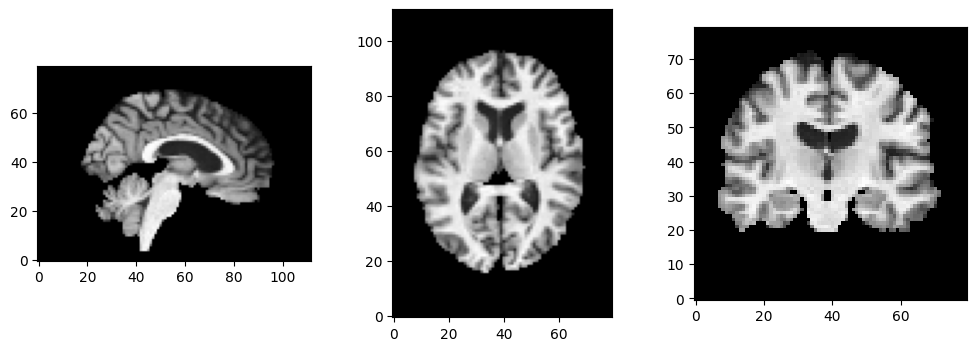

In [60]:
import numpy as np
import matplotlib.pyplot as plt


def show_slices_3planes(volume,axial_index=40,coronal_index=56,sagittal_index=40):
    axial_slice=volume[axial_index,:,:]
    coronal_slice=volume[:,coronal_index,:]
    sagittal_slice=volume[:,:,sagittal_index]
    fig,axes=plt.subplots(1,3,figsize=(12,4))

    axes[0].imshow(axial_slice.T,origin="lower",cmap="gray")
    axes[1].imshow(sagittal_slice.T,origin="lower",cmap="gray")
    axes[2].imshow(coronal_slice.T,origin="lower",cmap="gray")
    plt.show()

sample=dataset[0]["voxel"]
show_slices_3planes(sample,axial_index=40,coronal_index=56,sagittal_index=40)





tsne umap

In [61]:
# def extract_features(net,dataloder):
#     net.eval()
#     all_features=[]
#     all_labels=[]

#     with torch.no_grad():
#         for inputs,labels in dataloder:
#             inputs.to(device=device)
#             x=F.relu(net.fc1(net._forward_conv(inputs)))
#             x=x.cpu().numpy()
#             l=labels.numpy()
#             all_features.append(x)
#             all_labels.append(l)

#     all_features=np.concatenate(all_features,axis=0)
#     all_labels=np.concatenate(all_labels,axis=0)

#     return all_features,all_labels


import numpy as np

def extract_features(net, dataloader, device):
    """
    net: CNNクラス (forward_featuresメソッドが定義されている)
    dataloader: 特徴を抽出したいデータ一式
    device: torch.device("cuda" or "cpu")
    
    returns: (all_features, all_labels)
    """
    net.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            # GPU/CPUに乗せる
            inputs = inputs.to(device)
            
            # ★ 中間特徴を抽出 (ここで forward_features を呼ぶ!)
            x = net.forward_features(inputs)
            
            x = x.cpu().numpy()     # NumPyに変換
            l = labels.numpy()      # ラベルもCPUへ

            all_features.append(x)
            all_labels.append(l)

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_features, all_labels



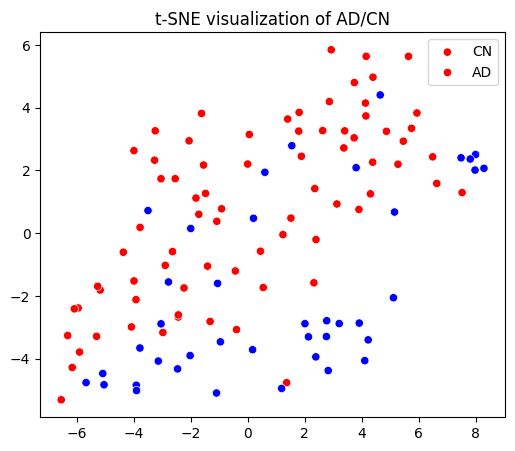

In [66]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# 例: モデルとデータの用意
# net = CNN()
# net.load_state_dict(...)  # 学習済み重みをロードする等
# val_dataloader = ...

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

features, labels_ = extract_features(net, val_dataloader, device)

tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)  # shape=(N,2)

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=features_2d[:,0],
    y=features_2d[:,1],
    hue=labels_,              # 0,1 のカテゴリで色分け
    palette=["red", "blue"],  # 0→red, 1→blue
    legend="full"
)

plt.title("t-SNE visualization of AD/CN")
plt.legend(labels=["CN", "AD"])  # 0:CN, 1:AD
plt.show()



In [68]:
# pip install umap-learn してから
import umap

reducer = umap.UMAP(n_components=2, random_state=0)
features_2d_umap = reducer.fit_transform(features)

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=features_2d[:,0],
    y=features_2d[:,1],
    hue=labels_,
    palette=["blue","red"],
    legend='full'
)

plt.title("UMAP visualization of AD/CN")
plt.legend(labels=["CN", "AD"])
plt.show()





AttributeError: module 'umap' has no attribute 'UMAP'